In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import re #Stopwords
import nltk #PortStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from kneed import KneeLocator

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\johnw\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\johnw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\johnw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Preprocessing

Combine -> preprocess -> shuffle

Shuffling the combined dataset for
Balanced distribution of classes: When you concatenate the two datasets (fake and true), you end up with all fake samples first, followed by all true samples. Shuffling the dataset ensures that you have a balanced and mixed distribution of both classes throughout the dataset. This is particularly important when you split the data into training and testing sets, as it helps to maintain a balanced class distribution in both subsets.

Reducing bias: Shuffling helps reduce the risk of introducing any potential biases that might be present in the order of the samples. If the samples are ordered in a certain way (e.g., by date, by author, or by topic), the model might learn patterns related to this order rather than the actual differences between fake and true news.

Improving model generalization: By shuffling the data, you ensure that the model is exposed to a variety of samples during training, which helps it learn to generalize better to unseen data. If the data is not shuffled, the model might overfit to specific patterns in the training data, which could hurt its performance on the test data.



In [4]:
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

# add labels to the datasets
fake_df['label'] = 0
true_df['label'] = 1

# preprocess the text data
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text.lower())  # remove non-word characters and convert to lowercase
    words = text.split()
    words = [WordNetLemmatizer().lemmatize(word) for word in words if word not in set(stopwords.words('english'))]  # remove stopwords and lemmatize
    return ' '.join(words)

# preprocess the text data for fake_df and true_df
fake_df['processed_text'] = fake_df['text'].apply(preprocess_text)
true_df['processed_text'] = true_df['text'].apply(preprocess_text)

# combine the datasets
news_df = pd.concat([fake_df, true_df], ignore_index=True)

# shuffle the combined dataset
news_df = news_df.sample(frac=1, random_state=42).reset_index(drop=True)

## Visualization: word cloud, class distribution, top frequent words by class

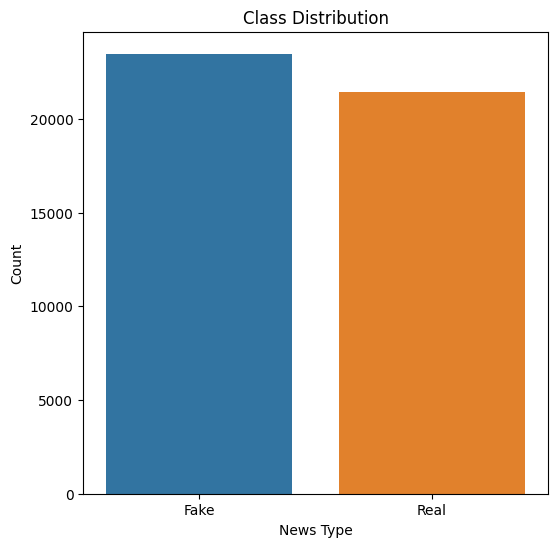

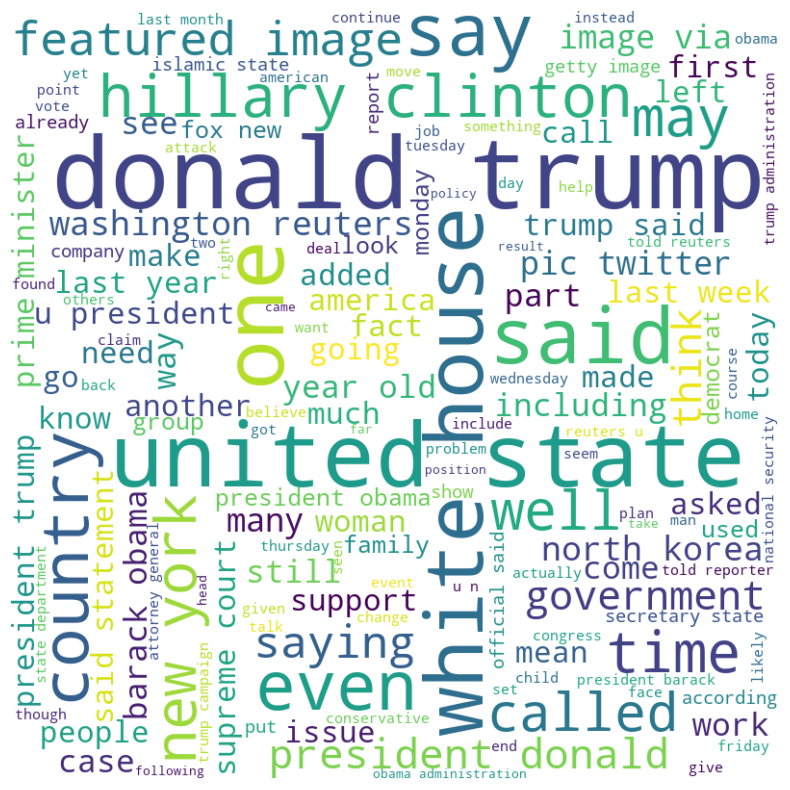

In [5]:
"""Visualize the class distribution"""
plt.figure(figsize=(6, 6))
sns.countplot(x='label', data=news_df)
plt.xlabel('News Type')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks([0, 1], ['Fake', 'Real'])
plt.show()

"""Word Cloud"""
# Combine all processed text
all_text = ' '.join(news_df['processed_text'].values)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=150).generate(all_text)

# Display the word cloud
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



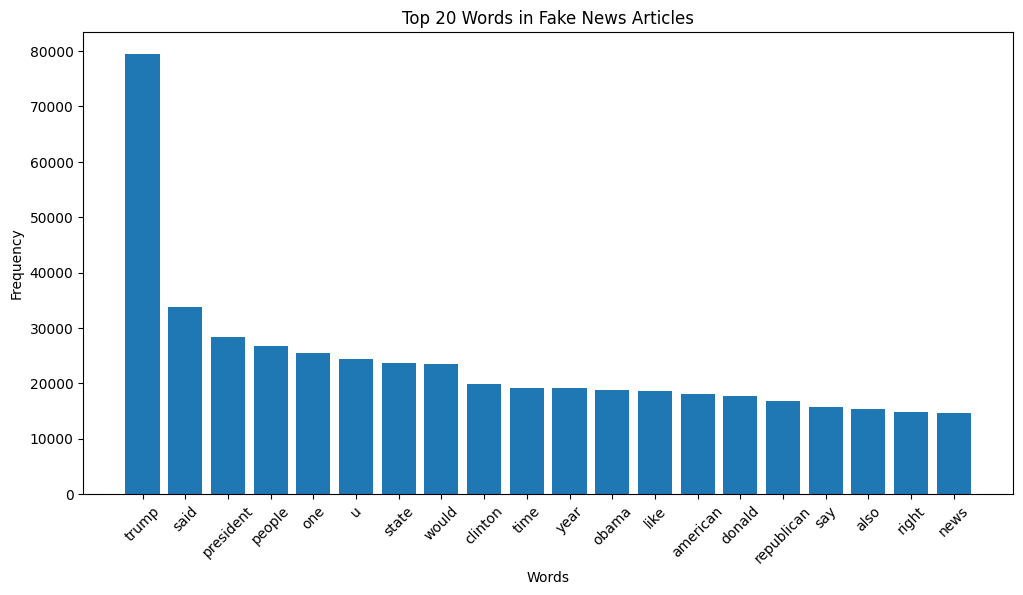

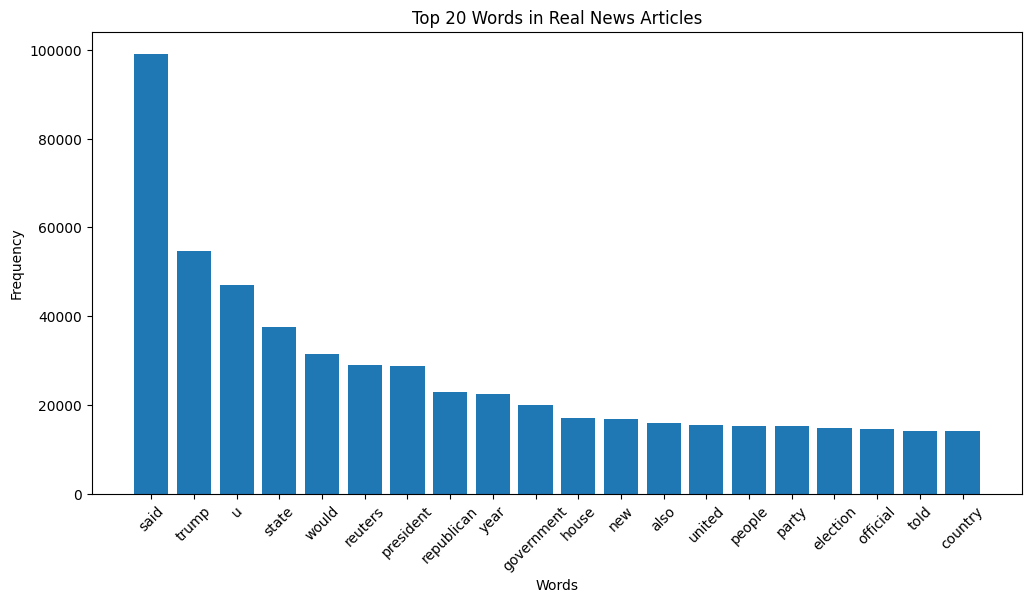

In [11]:
"""Top frequent words by class"""
def get_top_n_words(corpus, n=None):
    # Combine all texts in the corpus
    all_words = ' '.join(corpus).split()
    
    # Count the occurrences of each word
    word_freqs = Counter(all_words)
    
    # Get the n most common words
    top_n_words = word_freqs.most_common(n)
    
    return top_n_words

# Set the number of top words to display
n_top_words = 20

# Get the top 20 words for fake and real news separately
top_fake_words = get_top_n_words(fake_df['processed_text'], n_top_words)
top_real_words = get_top_n_words(true_df['processed_text'], n_top_words)

# New DataFrame for each class
fake_words_df = pd.DataFrame(top_fake_words, columns=['word', 'frequency'])
real_words_df = pd.DataFrame(top_real_words, columns=['word', 'frequency'])

# Plot the top words for fake news
plt.figure(figsize=(12, 6))
plt.bar(fake_words_df['word'], fake_words_df['frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Words in Fake News Articles'.format(n_top_words))
plt.xticks(rotation=45)
plt.show()

# Plot the top words for real news
plt.figure(figsize=(12, 6))
plt.bar(real_words_df['word'], real_words_df['frequency'])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top {} Words in Real News Articles'.format(n_top_words))
plt.xticks(rotation=45)
plt.show()



## Splitting the dataset into 60% train, 20% validation, and 20% test sets.

In [7]:
# split the dataset into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(news_df['processed_text'], news_df['label'], test_size=0.2, random_state=42)

# split the train set further into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


## Convert text data into numerical format by TF-IDF

ref:https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe

In [8]:
vectorizer = TfidfVectorizer()

# Scale the training data and also learn the scaling parameters(mean and variance of the features) of that data
# Resulting X_train_tfidf is a matrix containing the TF-IDF values for each word in training set.
X_train_tfidf = vectorizer.fit_transform(X_train)

# For validation and test sets, use transform() instead to transform the sets
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

## Supervised learning: implement linear SVC and MultinomialNB 
ref:https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
https://medium.com/@manoveg/multi-class-text-classification-with-probability-prediction-for-each-class-using-linearsvc-in-289189fbb100

https://towardsdatascience.com/multinomial-na%C3%AFve-bayes-for-documents-classification-and-natural-language-processing-nlp-e08cc848ce6

LinearSVC vs. SVC:
LinearSVC uses one-vs-the-rest scheme, SVC uses one vs one scheme for multiclass handling

MultinomialNB is designed for discrete data, such as word counts or term frequencies in text data. It assumes that the features follow a multinomial distribution, which is a reasonable assumption when working with text data, as it represents the number of occurrences of each word or term. This makes MultinomialNB a suitable choice for text classification tasks.

In [9]:
# Create and fit the Naïve Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_val_pred_nb = nb_classifier.predict(X_val_tfidf)

f1 = f1_score(y_val, y_val_pred_nb)
print(f"Multinomial Naïve Bayes F1 Score: {f1}")

# Create and fit the Linear SVM classifier
svm_classifier = LinearSVC()
svm_classifier.fit(X_train_tfidf, y_train)

# Predict on the validation set
y_val_pred_svm = svm_classifier.predict(X_val_tfidf)

f1 = f1_score(y_val, y_val_pred_svm)
print(f"Linear SVM F1 Score: {f1}")


Multinomial Naïve Bayes F1 Score: 0.9314649081488461
Linear SVM F1 Score: 0.9921811179834286


## hyperparameter tuning for supervised models and selection of model
F1 Score might be the most suitable metric to choose the best model. This is because both false positives (mislabeling true news as fake) and false negatives (mislabeling fake news as true) can have consequences.

Best Multinomial Naïve Bayes Parameters: {'alpha': 0.01}


C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best Linear SVM Parameters: {'C': 10}
Tuned Multinomial Naïve Bayes F1 Score: 0.9384651936326918
Tuned Linear SVM F1 Score: 0.9928779918272038
Tuned Multinomial Naïve Bayes Evaluation Metrics:
Accuracy: 0.9423
Precision: 0.9546
Recall: 0.9229
F1 Score: 0.9385


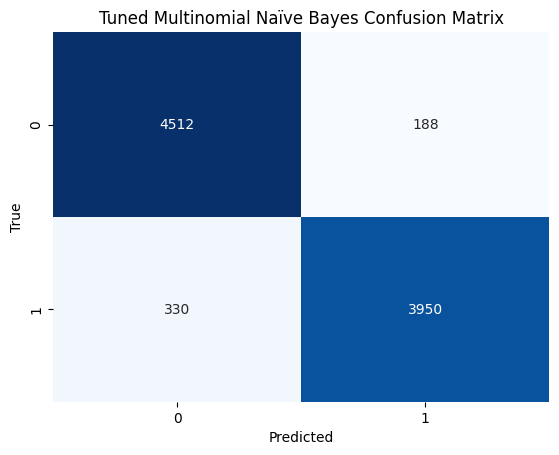

Tuned Linear SVM Evaluation Metrics:
Accuracy: 0.9932
Precision: 0.9923
Recall: 0.9935
F1 Score: 0.9929


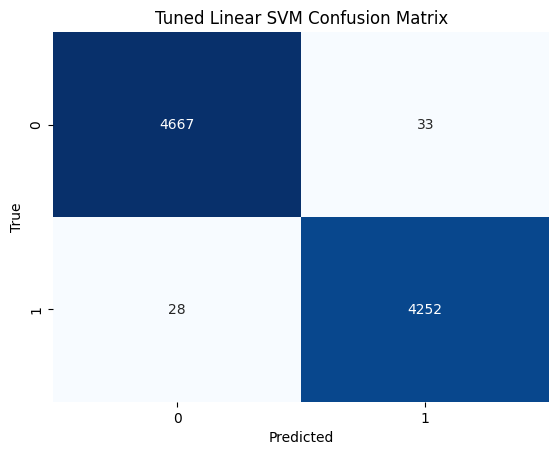

Best Model: Linear SVM


In [14]:
# NB hyperparameter tuning
nb_params = {'alpha': [0.01, 0.1, 0.5, 1, 1.5, 10, 100]}
grid_nb = GridSearchCV(MultinomialNB(), nb_params, scoring='accuracy', cv=5)
grid_nb.fit(X_train_tfidf, y_train)

best_nb = grid_nb.best_estimator_
print(f"Best Multinomial Naïve Bayes Parameters: {grid_nb.best_params_}")

# LinearSVM hyperparameter tuning
svm_params = {'C': [0.01, 0.1, 0.5, 1, 1.5, 10, 100]}
grid_svm = GridSearchCV(LinearSVC(), svm_params, scoring='accuracy', cv=5)
grid_svm.fit(X_train_tfidf, y_train)

best_svm = grid_svm.best_estimator_
print(f"Best Linear SVM Parameters: {grid_svm.best_params_}")

# Evaluate the tuned models on the validation set
y_val_pred_nb_tuned = best_nb.predict(X_val_tfidf)
y_val_pred_svm_tuned = best_svm.predict(X_val_tfidf)

# Calculate and print the F1 score for the tuned models
f1_nb_tuned = f1_score(y_val, y_val_pred_nb_tuned)
f1_svm_tuned = f1_score(y_val, y_val_pred_svm_tuned)
print(f"Tuned Multinomial Naïve Bayes F1 Score: {f1_nb_tuned}")
print(f"Tuned Linear SVM F1 Score: {f1_svm_tuned}")

def evaluate_display_metrics(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    print(f"{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    return f1

# Evaluate the tuned models on the validation set
f1_nb_tuned = evaluate_display_metrics(y_val, y_val_pred_nb_tuned, "Tuned Multinomial Naïve Bayes")
f1_svm_tuned = evaluate_display_metrics(y_val, y_val_pred_svm_tuned, "Tuned Linear SVM")

# Select the best model based on F1 score
best_model = best_nb if f1_nb_tuned > f1_svm_tuned else best_svm
best_model_name = "Multinomial Naïve Bayes" if f1_nb_tuned > f1_svm_tuned else "Linear SVM"
print(f"Best Model: {best_model_name}")


## Unsupervised learning with K-means clustering

find the optimal number of clusters using the <b>elbow method</b>

Choose the optimal number of clusters based on the elbow plot where the rate of decrease slows down 

using PCA for dimensionality reduction so that it can be visualized

#### Note: the K-means clustering algorithm is not specifically designed for classification tasks, so the accuracy might not be as high as with supervised learning algorithms.
This is an exploratory step in the project. aimed at learning about different techniques in data science and that it provides an opportunity to understand the limitations and strengths of various methods, to understand and compare its performance with supervised learning algorithms. 

In [15]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


# Determine the optimal number of clusters using the elbow method
distortions = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train_tfidf)
    distortions.append(kmeans.inertia_)

C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Apply PCA to reduce the dimension into 2D to visualize the clusters in a 2D plot

ref for elbow point finding:https://stackoverflow.com/questions/51762514/find-the-elbow-point-on-an-optimization-curve-with-python

clusters in 2D plot may overlap due to the difference between the PCA dimension and original dimension

C:\Users\johnw\anaconda3\envs\seem2460\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


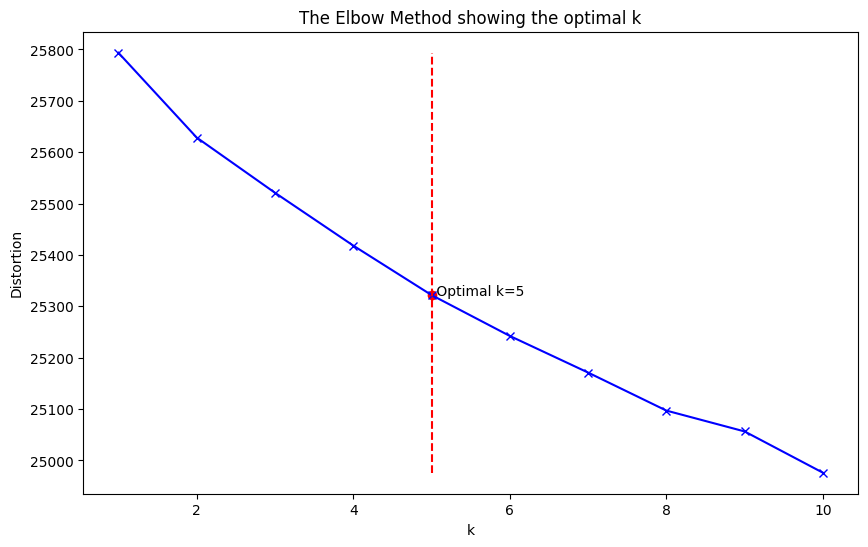

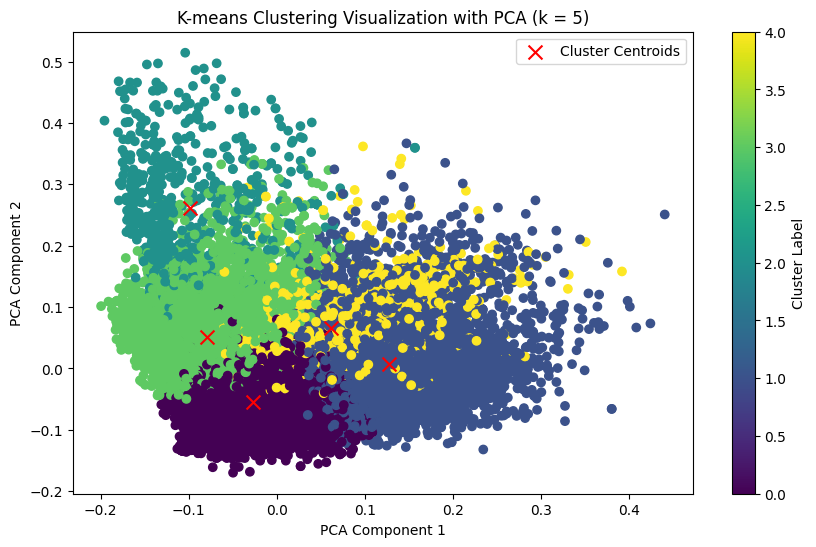

In [17]:
# Find the elbow point
kn = KneeLocator(K, distortions, curve='convex', direction='decreasing')
optimal_k = kn.elbow

# Apply K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k)
kmeans.fit(X_train_tfidf)

# Visualize the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Curve showing the optimal k')
plt.vlines(optimal_k, min(distortions), max(distortions), colors='r', linestyles='dashed')
plt.scatter(optimal_k, distortions[optimal_k-1], color='red')
plt.text(optimal_k, distortions[optimal_k-1], f' Optimal k={optimal_k}')
plt.show()

# Visualize the clusters using PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_tfidf.toarray())
cluster_centers_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans.labels_, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'K-means Clustering Visualization with PCA (k = {optimal_k})')
plt.colorbar().set_label('Cluster Label')

# Plot cluster centroids
plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], s=100, c='red', marker='x', label='Cluster Centroids')
plt.legend()
plt.show()


## Evaluation of K-means clustering
For each cluster, count the number of real and fake news articles in it. Assign the majority label to the cluster. For example, if Cluster 0 has more fake news articles than real news articles, its majority label would be "fake."

The accuracy below represents the ability of the K-means clustering model to correctly classify news articles as fake or true. The model learns to form clusters based on the patterns it identifies in the training data. By using majority voting to map cluster labels back to the original class labels, we can evaluate how well the clustering algorithm is able to separate fake and true news articles.

K-means Clustering (Validation Set) Evaluation Metrics:
Accuracy: 0.7910
Precision: 0.9060
Recall: 0.6264
F1 Score: 0.7407


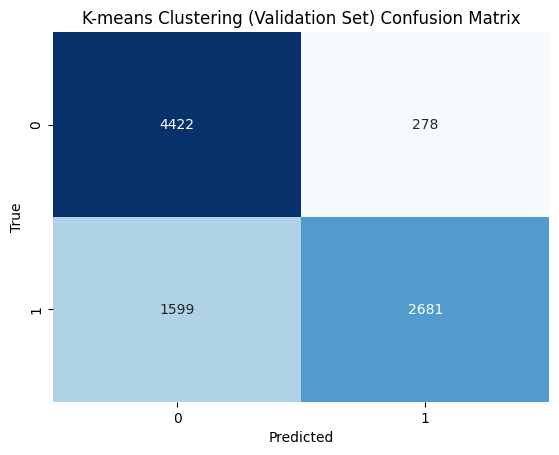

K-means Clustering (Test Set) Evaluation Metrics:
Accuracy: 0.7847
Precision: 0.9028
Recall: 0.6133
F1 Score: 0.7304


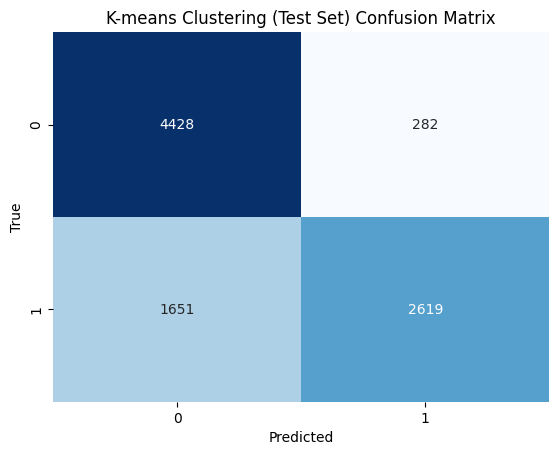

In [23]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, accuracy_score

def get_cluster_label_mapping(y_train, kmeans_labels):
    y_train_array = np.array(y_train)  # Convert y_train to a NumPy array
    cluster_labels = np.unique(kmeans_labels)
    majority_vote_labels = []

    for label in cluster_labels:
        indices = np.where(kmeans_labels == label)
        majority_label = np.argmax(np.bincount(y_train_array[indices]))
        majority_vote_labels.append(majority_label)

    return dict(zip(cluster_labels, majority_vote_labels))


cluster_label_mapping = get_cluster_label_mapping(y_train, kmeans.labels_)



# Apply K-means to the validation set
y_val_kmeans = kmeans.predict(X_val_tfidf)
y_val_kmeans_mapped = np.array([cluster_label_mapping[label] for label in y_val_kmeans])

# Apply K-means to the test set
y_test_kmeans = kmeans.predict(X_test_tfidf)
y_test_kmeans_mapped = np.array([cluster_label_mapping[label] for label in y_test_kmeans])

# Compute and display evaluation metrics for the validation set
val_kmeans_f1 = evaluate_display_metrics(y_val, y_val_kmeans_mapped, "K-means Clustering (Validation Set)")
# Compute and display evaluation metrics for the test set
test_kmeans_f1 = evaluate_display_metrics(y_test, y_test_kmeans_mapped, "K-means Clustering (Test Set)")


## Visualize most common terms in each cluster 

In [21]:
def get_top_features_cluster(tfidf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tfidf_array[id_temp], axis = 0) # average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out() 
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

top_features_per_cluster = get_top_features_cluster(X_train_tfidf.toarray(), kmeans.labels_, 10)

for i, df in enumerate(top_features_per_cluster):
    print(f"Cluster {i} Top Features:")
    print(df)
    print("\n")


Cluster 0 Top Features:
  features     score
0     said  0.022098
1  clinton  0.017848
2    trump  0.016726
3   people  0.016571
4    obama  0.015909
5   police  0.015056
6    state  0.015041
7      one  0.014087
8  hillary  0.013996
9     year  0.013736


Cluster 1 Top Features:
     features     score
0       trump  0.155829
1        said  0.039558
2     clinton  0.038155
3   president  0.036070
4      donald  0.035012
5  republican  0.034208
6    campaign  0.031323
7    election  0.025472
8       white  0.023736
9       house  0.022760


Cluster 2 Top Features:
    features     score
0      korea  0.258373
1      north  0.223389
2     korean  0.105685
3    nuclear  0.092241
4    missile  0.086180
5      china  0.076539
6      south  0.066453
7       said  0.061919
8  pyongyang  0.060932
9       test  0.049756


Cluster 3 Top Features:
     features     score
0        said  0.060007
1       state  0.033270
2  government  0.028345
3     reuters  0.028049
4    minister  0.027266
5     